In [1]:
"""
Purpose: Implementation fo DiffPool
graph coarsening manner

"""

'\nPurpose: Implementation fo DiffPool\ngraph coarsening manner\n\n'

In [2]:
%load_ext autoreload
%autoreload 2

# Repos to Add For All Modules

In [ ]:
"""
Bash command

cd /
git clone https://github.com/celiibrendan/python_tools
git clone https://github.com/celiibrendan/machine_learning_tools.git
git clone https://github.com/celiibrendan/neuron_morphology_tools.git
git clone https://github.com/celiibrendan/pytorch_tools.git

"""

In [3]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/python_tools/python_tools")
sys.path.append("/machine_learning_tools/machine_learning_tools/")
sys.path.append("/pytorch_tools/pytorch_tools/")
sys.path.append("/neuron_morphology_tools/neuron_morphology_tools/")


from importlib import reload

In [5]:
#python_tools modules
import system_utils as su
import pandas_utils as pu
import pandas as pd
import numpy as np
import numpy_utils as nu
import networkx_utils as xu
from tqdm_utils import tqdm

#neuron_morphology_tools modules
import neuron_nx_io as nxio

In [6]:
import torch
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data
from torch_geometric import transforms

# for the dataset object
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.loader import DataLoader
from torch_geometric.data import DenseDataLoader

In [7]:
#pytorch_tools modules
import preprocessing_utils as pret
import geometric_models as gm
import geometric_dataset_utils as gdu

# Step 0: Choosing the Model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

new_label_name = "cell_type_fine_label_clf"
data_name = "data"

device = cpu


# Step 1: Preprocessing the Graph Data

# a) Getting the Cell Type Labels

In [1]:
accessing_data_through_datajoint = True
if accessing_data_through_datajoint: 
    sys.path.append("/meshAfterParty/meshAfterParty/")
    import datajoint_utils as du
    import cell_type_utils as ctu
    from dataInterfaceMinnie65 import data_interface as hdju

NameError: name 'sys' is not defined

In [10]:
import pandas_utils as pu
def fetch_cell_type_fine_labels_df():
    
    import allen_utils as alu
    alu.initialize_client()
    alu.set_version_to_latest()
    
    import cell_type_utils as ctu
    df = ctu.cell_type_df_allen_bcm(verbose = True)
    df_fine = ctu.df_cell_type_fine(df)
    df_fine = pu.rename_columns(df_fine,dict(cell_type_fine = "cell_type_fine_label"))
    return df_fine

df_fine = fetch_cell_type_fine_labels_df()

ERROR! Session/line number was not unique in database. History logging moved to new session 72
---Working on bodor_pt_cells---
---Working on allen_column_l5it_types---
---Working on allen_column_basket_molecular---
---Working on allen_column_bodor_surround_inhib---
---Working on l5_mc_cg---
---Working on allen_v1_column_types_slanted---
---Working on allen_minnie_extra_types---
---Working on allen_v1_column_types_v2---
---Working on allen_v1_column_pyc_proof---
---Working on pt_synapse_targets---
---Working on cg_cell_type_calls---
len(cell_type_allen) = 5542
len(cell_type_bcm) = 585
len(cell_type_df) before filtering = 6096
len(cell_type_df) after filtering = 6096


In [11]:
new_map = {
    'IT_short': '5P-IT',
    'bc': 'BC',
    'Martinotti': 'MC',
    'IT_small_tuft': '5P-IT',
    '5P_NP': '5P-NP',
    '5P_PT': '5P-PT',
    'sst': 'SST',
    'VIP': None,
    'ndnf+npy-': None,
    'Pvalb': 'Pvalb',
    'bpc': 'BPC',
    'IT_big_tuft': '5P-IT',
    'prox targeting': None,
    'l1vip': None,
    'I targeting non-bpc': None,
    'ngfc': 'NGC',
    'alfa7': None,
    'cb1 basket': None,
    'np-targeting': None,
    'small basket': 'BC',
    'CCK': None,
    'chandelier': None,
    'PT': None,
    'IT': None,
    'basket': 'BC',
    'npy': None,
    'MC': 'MC',
    '6P': None,
    '5P_IT': '5P-IT',
    '5P': None,
    '23P': '23P',
    '4P': '4P',
    '1P': None,
    'INH': None,
    'Unsure E': None,
    'Unsure I': None,
    'ndnf+npy_': None,
    'I targeting non_bpc': None,
    'BPC': 'BPC',
    'SST': 'SST',
    'BC': 'BC',
    'np_targeting': None,
    'Unsure': None,
    'NGC': 'NGC',
    '6P_IT': '6P-IT',
    '6P_U': None,
    '6P_CT': '6P-CT',
    'WM_P': None,
    '6CT': '6P-CT'
}

In [12]:
df_labels = pu.rename_columns(
    df_fine,
    dict(pt_root_id="segment_id",
        cell_type_fine_label = new_label_name)
    )[["segment_id","nucleus_id",new_label_name]]
df_labels[new_label_name] = pu.new_column_from_dict_mapping(
    df_labels,
    new_map,
    new_label_name,)
df_labels

,segment_id,nucleus_id,cell_type_fine_label_clf
0,864691135660737776,526436,5P-PT
1,864691135472306482,495010,5P-PT
2,864691135494401680,494888,5P-PT
3,864691135502157405,337966,5P-PT
4,864691135476398504,302951,5P-PT
...,...,...,...
5536,864691135939789313,371770,None
5538,864691135939790081,164927,5P-IT
5539,864691135501851970,273900,None
5540,864691136020226040,222567,23P


# b) Getting the graph Data

In [13]:
if accessing_data_through_datajoint:
    nucleus_ids = df_labels["nucleus_id"].to_numpy()
    table = (hdju.proofreading_neurons_table & [dict(nucleus_id=k) for k in nucleus_ids])
    table
else:
    table = None
    
table

segment_id id of the segment under the nucleus centroid. Equivalent to Allen 'pt_root_id'.,decimation_method hash,mesh_fragment_method_set hash,decomposition_method hash,decomposition_split_method hash,decomposition_cell_type_method hash,split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,auto_proofread_neuron_method hash,multiplicity the total number of neurons that came from the parent segment id,cell_type_used,cell_type,nucleus_id id of nucleus from the flat segmentation Equivalent to Allen: 'id'.,nuclei_distance the distance to the closest nuclei (even if no matching nuclei found),n_nuclei_in_radius the number of nuclei within the search radius of 15000 belonging to that segment,n_nuclei_in_bbox the number of nuclei within the bounding box of that soma,centroid_x (EM voxels),centroid_y (EM voxels),centroid_z (EM voxels),centroid_x_nm nm x coordinate of soma,centroid_y_nm nm y coordinate of soma,centroid_z_nm nm z coordinate of soma,centroid_volume,max_soma_n_faces The largest number of faces of the somas,max_soma_volume The largest volume of the somas the (volume in billions (10*9 nm^3)),max_soma_area The largest surface area of the somas (area in um),syn_density_post_after_proof,syn_density_head_after_proof,syn_density_neck_after_proof,syn_density_shaft_after_proof,skeletal_length_processed_syn_after_proof,spine_density_after_proof,skeletal_length_processed_spine_after_proof,baylor_cell_type_after_proof,baylor_cell_type_exc_probability_after_proof,baylor_cell_type,baylor_cell_type_exc_probability,external_cell_type,cell_type_used_for_axon,cell_type_for_axon,external_cell_type_n_nuc,external_cell_type_fine,external_layer,external_visual_area,axon_angle_max,axon_angle_min,n_axon_angles,axon_start_distance_from_soma,n_vertices number of vertices,n_faces number of faces,n_limbs,n_branches,max_limb_n_branches,skeletal_length,max_limb_skeletal_length,median_branch_length gives information on average skeletal length to next branch point,width_median median width from mesh center without spines removed,width_no_spine_median median width from mesh center with spines removed,width_90_perc 90th percentile for width without spines removed,width_no_spine_90_perc 90th percentile for width with spines removed,n_spines,n_boutons,spines_per_branch,skeletal_length_eligible the skeletal length for all branches searched for spines,n_spine_eligible_branches the number of branches that were checked for spines because passed width threshold,spine_density_eligible n_spines/skeletal_length_eligible,spines_per_branch_eligible n_spines/n_spine_eligible_branches,total_spine_volume the sum of all spine volume,spine_volume_median median of the spine volume for those spines with able to calculate volume,spine_volume_density total_spine_volume/skeletal_length,spine_volume_density_eligible total_spine_volume/skeletal_length_eligible,spine_volume_per_branch_eligible total_spine_volume/n_spine_eligible_branches,dendrite_skeletal_length,dendrite_area,dendrite_mesh_volume,dendrite_n_branches,axon_skeletal_length,axon_area,axon_mesh_volume,axon_n_branches,basal_skeletal_length,basal_area,basal_mesh_volume,basal_n_branches,apical_skeletal_length,apical_area,apical_mesh_volume,apical_n_branches,apical_tuft_skeletal_length,apical_tuft_area,apical_tuft_mesh_volume,apical_tuft_n_branches,apical_shaft_skeletal_length,apical_shaft_area,apical_shaft_mesh_volume,apical_shaft_n_branches,oblique_skeletal_length,oblique_area,oblique_mesh_volume,oblique_n_branches,apical_total_skeletal_length,apical_total_area,apical_total_mesh_volume,apical_total_n_branches,n_syn_valid,n_syn_valid_pre,n_syn_valid_post,n_syn_error,n_syn_error_pre,n_syn_error_post,n_syn_presyns_on_dendrite,n_syn_mesh_errored,n_syn_distance_errored,n_syn_no_label,n_syn_head,n_syn_neck,n_syn_shaft,n_syn_no_head,n_syn_bouton,n_syn_non_bouton,n_syn_dendrite,n_syn_axon,n_syn_basal,n_syn_apical,n_syn_apical_tuft,n_syn_apical_shaft,n_syn_oblique,n_syn_soma,n_syn_apical_total,n_s

In [14]:
features_to_output = [
    "n_spines",
    "total_spine_volume",
    "n_synapses_post",
    "n_synapses_pre",
    "n_synapses_head",
    "n_synapses_neck",
    #"parent_skeletal_angle",
    "skeletal_length",
    "skeleton_vector_upstream_theta",
    "skeleton_vector_upstream_phi",
    "skeleton_vector_downstream_theta",
    "skeleton_vector_downstream_phi",
    "width_upstream",
    "width_no_spine",
    "width_downstream",
    ]

import neuron_nx_utils as nxu
import neuron_nx_feature_processing as nxf
import networkx_utils as xu
import networkx as nx
def filter_graph(
    G,
    remove_starter_branches = True,
    distance_threshold = None,
    distance_threshold_min=None,
    features_to_output = features_to_output,
    verbose = False
    ):
    """
    Purpose: To filter the graph object
    before the GNN processes
    
    Pseudocode: 
    1) Reduces to only dendrite subgraph
    2) Removes any small starter nodes
    3) Restricts to a certain distance
    4) Filter to certain features
    5) Filter into soma 
    6) Turn into non-directed graph
    """
    
    #1) Reduces to only dendrite subgraph
    G = nxu.dendrite_subgraph(G)
    
    #2) Removes any small starter nodes
    if remove_starter_branches:
        G_filt = nxu.remove_small_starter_branches(
            G,
            verbose = verbose,
            maintain_skeleton_connectivity = True)
    else:
        G_filt = G
        
    #3) Restricts to a certain distance
    if distance_threshold is not None:
        G_dist_filt = nxu.nodes_within_distance_upstream_from_soma(
            G_filt,
            verbose = verbose,
            distance_threshold = distance_threshold,
            return_subgraph = True,
        )
    else:
        G_dist_filt = G_filt
        
    if distance_threshold_min is not None:
        G_dist_filt = nxu.nodes_farther_than_distance_from_soma(
            G_dist_filt,
            verbose = verbose,
            distance_threshold = distance_threshold_min,
            return_subgraph = True,
            distance_type = "downstream",
        )
        

    #4) Filter to certain features
    if ((len(nxu.limb_branch_subgraph(G_dist_filt).nodes()) > 0)
        and (features_to_output is not None)):
        G_with_feats = nxf.filter_G_features(
                    G_dist_filt,
                    features=features_to_output,
                    inplace = False,
                    verbose = verbose,
                )
    else:
        G_with_feats = G_dist_filt
    
    
    #5) Filter into soma 
    G_no_soma = nxu.soma_filter_by_complete_graph(G_with_feats,plot=False)
    
    #6) Turn into non-directed graph
    G_no_soma = nx.Graph(G_no_soma)
    
    return G_no_soma

In [15]:
from tqdm_utils import tqdm
def fetch_graphs(
    segment_ids=None,
    split_indexes = None,
    nucleus_ids = None,
    n_obj = None,
    table = None,
    verbose = False,
    
    filter_func = filter_graph,
    
    # for returning a smaller dataset
    return_compressed_df = True,
    features = features_to_output,
    ):
    """
    Purpose: To return graph objects with the 
    """
    
    if nucleus_ids is not None:
        table = (hdju.proofreading_neurons_table & [dict(nucleus_id=k) for k in nucleus_ids])
        
    if segment_ids is None:
        if table is None: 
            table = hdju.proofreading_neurons_table
        segment_ids,split_indexes = table.fetch("segment_id","split_index")
        
        
    if split_indexes is None:
        split_indexes = [0]*len(segment_ids)
        
    if n_obj is not None:
        segment_ids = segment_ids[:n_obj]
        split_indexes = split_indexes[:n_obj]
        
    if verbose:
        print(f"Pullling Down {len(segment_ids)} Neurons")
        
    graphs = []
    for s,sp in tqdm(zip(segment_ids,split_indexes)):
        
        G = hdju.graph_obj_from_auto_proof_stage(s,sp)
        
        # filtering the graph
        if filter_func is not None:
            G = filter_graph(G)
        
        if return_compressed_df:
            G = nxio.compressed_dict_from_G(
                G,
                features=features,
                data_name = data_name)
            
        graphs.append(G)
        
        
    if return_compressed_df:
        return pd.DataFrame.from_records(graphs)
    else:
        return graphs

data_df_no_label = fetch_graphs(
    segment_ids=None,
    split_indexes = None,
    verbose = True,
    table = table,
    #n_obj = 100,
)

Pullling Down 3477 Neurons


0it [00:00, ?it/s]

# d) Labeling the Graphs (and determining numerical identifiers)

In [16]:
import pandas as pd
data_df = pd.merge(
    data_df_no_label,
    df_labels,
    on=["segment_id","nucleus_id"],
    how="left"
)

data_df

,segment_id,split_index,nucleus_id,external_layer,data,cell_type_fine_label_clf
0,864691134884748026,0,366181,LAYER_5,"{'nodelist': ['L0_10', 'L0_11', 'L0_12', 'L0_7...",4P
1,864691134884761338,0,458241,LAYER_4,"{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3', ...",23P
2,864691134884769786,0,592718,LAYER_5,"{'nodelist': ['L0_18', 'L0_11', 'L0_17', 'L0_3...",5P-IT
3,864691134884879610,0,304873,LAYER_5,"{'nodelist': ['L0_6', 'L0_14', 'L3_3', 'L0_1',...",5P-IT
4,864691134884945146,0,63499,LAYER_2/3,"{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3', ...",23P
...,...,...,...,...,...,...
3472,864691137197239105,0,262000,LAYER_4,"{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3', ...",4P
3473,864691137197241665,0,308938,LAYER_6,"{'nodelist': ['L1_8', 'L3_3', 'L0_24', 'L2_1',...",None
3474,864691137197306177,0,304611,LAYER_5,"{'nodelist': ['L0_1', 'L0_3', 'L0_6', 'L0_0', ...",5P-NP
3475,864691137197321281,0,434601,LAYER_5,"{'nodelist': ['L0_6', 'L0_14', 'L3_3', 'L0_1',...",None


In [17]:
import system_utils as su
su.compressed_pickle(data_df,"cell_type_fine_gnn_df")

In [18]:
total_labels,label_counts = np.unique((data_df.query(
    f"{new_label_name}=={new_label_name}")[
new_label_name]).to_numpy(),return_counts = True)
cell_type_map = {k:i for i,k in enumerate(total_labels)}
cell_type_map

{'23P': 0,
 '4P': 1,
 '5P-IT': 2,
 '5P-NP': 3,
 '5P-PT': 4,
 '6P-CT': 5,
 '6P-IT': 6,
 'BC': 7,
 'BPC': 8,
 'MC': 9,
 'NGC': 10,
 'Pvalb': 11,
 'SST': 12}

# e) Get the normalization factors

In [38]:
def fetch_normalization_df():
    return hdju.gnn_normalization_df()[data_df.loc[0,"data"]["features"]]

normalization_df= fetch_normalization_df()
display(normalization_df)

,n_spines,n_synapses_head,n_synapses_neck,n_synapses_post,n_synapses_pre,skeletal_length,total_spine_volume,width_upstream,width_downstream,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine
norm_mean,20.8024,13.8207,0.614392,48.0761,0.329718,48828.8,4.921390e+09,399.163,369.903,-0.143175,1.593600,-0.151569,1.586410,361.467
norm_std,25.7662,17.7472,1.276590,52.7823,1.056460,45959.7,6.593180e+09,180.745,203.958,1.827830,0.684837,1.830730,0.685505,164.403


In [39]:
if normalization_df is None:
    normalization_df = gdu.normalization_df(
            data_df=data_df,
            column = data_name,
            data_extraction_func=nxio.feature_df_from_gnn_info,
            verbose = True,
        
            #kwargs for the data extraction function
            return_data_labels_split = False
            )
    
normalization_df

,n_spines,n_synapses_head,n_synapses_neck,n_synapses_post,n_synapses_pre,skeletal_length,total_spine_volume,width_upstream,width_downstream,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine
norm_mean,20.8024,13.8207,0.614392,48.0761,0.329718,48828.8,4.921390e+09,399.163,369.903,-0.143175,1.593600,-0.151569,1.586410,361.467
norm_std,25.7662,17.7472,1.276590,52.7823,1.056460,45959.7,6.593180e+09,180.745,203.958,1.827830,0.684837,1.830730,0.685505,164.403


# 2) Creating the Dataset for the model

In [40]:
model_name = "GCNFlat"
max_nodes = 300

model_class = getattr(gm,model_name)
dense_adj = getattr(model_class,"dense_adj",False)
directed = getattr(model_class,"directed",False)
print(f"dense_adj= {dense_adj}, directed = {directed}")


dense_adj= False, directed = False


In [41]:
gnn_task_name = "cell_type_fine"
graph_label = new_label_name

data_filepath = None
data_source = "m65"
output_folder = "./"
    
processed_data_folder_name = f"{gnn_task_name}"
only_process_labeled = True

In [42]:
m65_dataset = gdu.load_data(
    data_column=data_name,
    graph_label=new_label_name,
    data_extraction_func=nxio.feature_df_from_gnn_info,
    gnn_task_name = gnn_task_name,
    output_folder=output_folder,
    
    # -- dataset arguments ---
    data_df = data_df,
    data_filepath = data_filepath,

    
    #for the standardization
    df_standardization = normalization_df,
    
    
    # for the mapping of the labels to integers
    label_int_map = cell_type_map,
    
    # For prepping dataset
    dense_adj = dense_adj,
    directed = directed,
    features_to_delete = None,
    features_to_keep = None,
    processed_data_folder_name = processed_data_folder_name,
    max_nodes = max_nodes,
    
    #--------- processing the dataset ----
    clean_prior_dataset = False,
    
    # for appending 
    data_source = data_source,
    verbose = True,
    
    only_process_labeled = only_process_labeled,
    return_label_int_map = False,
    
)

Starting to load data
Finished loading data: 4.76837158203125e-07
max_nodes = 300
Using precomputed cell map


Processing...


0it [00:00, ?it/s]

Done!


# b) Prinint out the resultant Dataset

In [43]:
dataset = m65_dataset

In [44]:
dataset_num_node_features = dataset.num_node_features
dataset_num_classes = dataset.num_classes

In [45]:
# looking at the dataset
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset_num_node_features}')
print(f'Number of classes: {dataset_num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: CellTypeDataset(3114):
Number of graphs: 3114
Number of features: 14
Number of classes: 13

Data(x=[49, 14], edge_index=[2, 82], y=[1, 1], data_name='864691134884748026_0', data_source='m65')
Number of nodes: 49
Number of edges: 82
Average node degree: 1.67
Has isolated nodes: True
Has self-loops: False
Is undirected: True


# --- c) Splitting the Data into Labeled and unlabeled

In [46]:
labeled_mask = np.array(
    [True if k.y[0][0] >= 0 else False for k in dataset]
).astype('int')
dataset_labeled = dataset[np.where(labeled_mask)[0]]
len(dataset_labeled)

2931

In [47]:
dataset_curr = dataset_labeled
torch.manual_seed(12345)
dataset_curr = dataset_curr.shuffle()

# --- d) Split Train/Validation/Test

In [48]:
"""
Purpose: To turn percentages into raw lengths

"""

'\nPurpose: To turn percentages into raw lengths\n\n'

In [49]:
batch_size = 64

(train_dataset,
val_dataset,
test_dataset,) = pret.train_val_test_split(
    dataset_curr,
    return_dict=False,
    verbose = True)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')

test size = 586.0 (0.2 %)
validation size = 586.0 (0.2 %)
train_size = 1759.0
data_lengths_with_train = [1759  586  586]
Number of training graphs: 1759
Number of test graphs: 586
Number of val graphs: 586


In [50]:
if dense_adj:
    data_loader_mod = DenseDataLoader
else:
    data_loader_mod = DataLoader


train_loader = data_loader_mod(train_dataset, batch_size=batch_size,shuffle = True)
test_loader = data_loader_mod(test_dataset, batch_size=batch_size,shuffle=False)
val_loader = data_loader_mod(val_dataset, batch_size=batch_size,shuffle=False)

# Step 3: Picking the Model

In [68]:
n_epochs = 300
n_hidden_channels = 128
global_pool_type = "mean"
n_layers = 2
use_bn = True
lr=0.0003

import general_utils as gu
architecture_kwargs_global = dict(
    n_hidden_channels = n_hidden_channels, 
    #n_hidden_channels=64, 
    #first_heads=8, 
    #output_heads=1, 
    #dropout=0.6,
    global_pool_type=global_pool_type,
    n_layers = n_layers,
    use_bn=use_bn,
    #classifier_type = "Flat",
)

optimizer_kwargs_global = dict(
    lr=lr
)

all_run_kwargs = [
    dict()
#     dict(architecture_kwargs = {'n_hidden_channels': 8, 'global_pool_type': 'mean', 'n_layers': 2,}),
    
#     dict(architecture_kwargs = {'n_hidden_channels': 64, 'global_pool_type': 'mean', 'n_layers': 3,
#                                 # "use_bn":False, "n_hidden_layers_classifier": 0
#                                 }),
#     dict(architecture_kwargs = {'n_hidden_channels': 128, 'global_pool_type': 'mean', 'n_layers': 3,}),
#     dict(architecture_kwargs = {'n_hidden_channels': 8, 'global_pool_type': 'mean', 'n_layers': 3,}),
]

# Step 3: Training the Model

In [69]:
import evaluation_utils as evu
import torch.nn.functional as F
import model_utils as mdlu
verbose = True

In [70]:
lab,cnt = np.unique(data_df.query(f"{new_label_name}=={new_label_name}")[new_label_name].to_numpy(),return_counts=True)
for l,c in zip(lab,cnt):
    print(f"{l}:{c}")

23P:905
4P:734
5P-IT:457
5P-NP:73
5P-PT:144
6P-CT:130
6P-IT:204
BC:83
BPC:66
MC:75
NGC:17
Pvalb:6
SST:37


In [71]:
cell_type_fine_classifier_weights = {
'23P': 0.25,#1294
'4P': 0.3,#890
'5P-IT': 0.5,#465
'6P': 0.8,#342
'6P-IT': 0.8,#263
'5P-PT': 0.8,#224
'5P-CT': 0.8,#224
}


class_idx = np.array(list(cell_type_map.values()) )
class_labels = np.array(list(cell_type_map.keys()) )
weights = np.array([cell_type_fine_classifier_weights.get(k,1) for k in class_labels])
weights = weights[np.argsort(class_idx)]

class_weights = torch.FloatTensor(weights).to(device)
class_weights

tensor([0.2500, 0.3000, 0.5000, 1.0000, 0.8000, 1.0000, 0.8000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])

# -- Setting up the tensorboard and checkpoint directories --

In [72]:
model_suffix = "test"
data_type = "m65"

In [73]:
tensorboard_dir = Path("./tensorboard/")
tensorboard_dir.mkdir(exist_ok=True)
tensorboard_dir = tensorboard_dir / Path(f"{data_type}")
tensorboard_dir.mkdir(exist_ok=True)
if model_suffix is not None:
    tensorboard_dir = tensorboard_dir / Path(f"{model_name}_{model_suffix}")
else:
    tensorboard_dir = tensorboard_dir / Path(f"{model_name}") 
print(f"tensorboard_dir = {tensorboard_dir}")

checkpoint_dir = Path("./model_checkpoints")
checkpoint_dir.mkdir(exist_ok = True)
checkpoint_dir = checkpoint_dir / Path(f"{data_type}")
checkpoint_dir.mkdir(exist_ok=True)
if model_suffix is not None:
    checkpoint_dir = checkpoint_dir / Path(f"{model_name}_{model_suffix}")
else:
    checkpoint_dir = checkpoint_dir / Path(f"{model_name}")
    
print(f"checkpoint_dir= {checkpoint_dir}")

tensorboard_dir = tensorboard/m65/GCNFlat_test
checkpoint_dir= model_checkpoints/m65/GCNFlat_test


In [74]:
# su.rm_dir(tensorboard_dir)
# su.rm_dir(checkpoint_dir)

In [75]:
checkpoint_dir.mkdir(exist_ok = True)
tensorboard_dir.mkdir(exist_ok = True)

# -- Training Loop -- 

In [76]:
import train_test_geometric_utils as ttu

for j,config_dict in enumerate(all_run_kwargs):
    
    # -----Part A: Configuring the model  ------
    architecture_kwargs = config_dict.get("architecture_kwargs",dict())
    optimizer_kwargs = config_dict.get("optimizer_kwargs",dict())
    
    architecture_kwargs = gu.merge_dicts([architecture_kwargs_global.copy(),architecture_kwargs])
    optimizer_kwargs = gu.merge_dicts([optimizer_kwargs_global.copy(),optimizer_kwargs])
    
    run_kwargs = gu.merge_dicts([architecture_kwargs,optimizer_kwargs])

    
    if verbose:
        print(f"\n\n\n****------ Running Model Config {j} with following parameters ------****\n{run_kwargs}")

    model = getattr(gm,model_name)(
        dataset_num_node_features=dataset_num_node_features,
        dataset_num_classes=dataset_num_classes,
        **architecture_kwargs
        )

    optimizer = torch.optim.Adam(model.parameters(), **optimizer_kwargs)
    print(model)


    
    # ----- Part B: Configuring the Tensorboard and Checkpoinns--------------
    from torch.utils.tensorboard import SummaryWriter

    

    tensorboard_file_name = (f'{model_name}_' 
                             + "_".join([f"{k}_{v}" for k,v in run_kwargs.items()]))
    print(f"tensorboard_file_name = {tensorboard_file_name}")
    tensorboard_file = tensorboard_dir / Path(f'{tensorboard_file_name}')
    try:
        su.rm_dir(tensorboard_file)
    except:
        pass
    tensorboard_file.mkdir(exist_ok = True)


    #-- when to save a checkpoint of the model
    checkpoint_path = checkpoint_dir / Path(f"./{tensorboard_file_name}_checkpoints")

    try:
        su.rm_dir(checkpoint_path)
    except:
        pass

    checkpoint_path.mkdir(exist_ok = True)
    n_epoch_for_checkpoint = 5

    writer = SummaryWriter(tensorboard_file)
    

    # ----- Part C: Test and Training Loops --------------
    print(model)
    
    class_weights = torch.FloatTensor(weights).to(device)
    tensor_map = None

    log_to_tensorboard = True
    for epoch in range(0, n_epochs):
        loss = ttu.forward_pass(
            model,
            data_loader = train_loader,
            optimizer=optimizer,
            model_name = model_name,
            mode = "train",
            class_weights = class_weights)
        writer.add_scalar('loss',loss,epoch) # new line
        
        train_metric_dict = ttu.forward_pass(
            model,
            data_loader = train_loader,
            optimizer=optimizer,
            model_name = model_name,
            mode = "test",)
        val_metric_dict = ttu.forward_pass(
            model,
            data_loader = val_loader,
            optimizer=optimizer,
            model_name = model_name,
            mode = "test",)

        if epoch % n_epoch_for_checkpoint == 0 and epoch != 0:
            val_acc = val_metric_dict['accuracy'].numpy()
            checkpoitn_filepath = checkpoint_path / Path(f"{tensorboard_file_name}_epoch_{epoch}")#_val_acc_{val_acc:.2f}")
            print(f"Saving off checkpoint {checkpoitn_filepath}")
            mdlu.save_checkpoint(model,filepath = checkpoitn_filepath,epoch = epoch,loss = loss)


        print(f'Epoch: {epoch:03d}, loss = {loss}')
        for type_name,metric_dict in zip(["train","val"],[train_metric_dict,val_metric_dict]):
            print_log = f"   {type_name} metrics: "
            for k,v in metric_dict.items():
                if log_to_tensorboard:
                    writer.add_scalar(f'{type_name}_{k}',v,epoch)
                print_log += f" {k}: {v:4f},"

            print(print_log)




****------ Running Model Config 0 with following parameters ------****
{'n_hidden_channels': 128, 'global_pool_type': 'mean', 'n_layers': 2, 'use_bn': True, 'lr': 0.0003}
GCNFlat(
  (conv0): GCNConv(14, 128)
  (bn0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GCNConv(128, 128)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=128, out_features=13, bias=True)
)
tensorboard_file_name = GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_use_bn_True_lr_0.0003
GCNFlat(
  (conv0): GCNConv(14, 128)
  (bn0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GCNConv(128, 128)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=128, out_features=13, bias=True)
)
   y_true_unique= [ 0  1  2  3  4  5  6  7  8  9 10 11 12],y_true_counts = [532 455 266  49  77  81

KeyboardInterrupt: 

# Step 4: Picking the best model

In [77]:
tensorboard_dir.absolute()

PosixPath('/neuron_mesh_tools/Auto_Proofreading/Minnie65_vs_H01/GNN_Cell_Types/Cell_Type_Fine_CLF/tensorboard/m65/GCNFlat_test')

In [79]:
%reload_ext tensorboard
%tensorboard --logdir /neuron_mesh_tools/Auto_Proofreading/Minnie65_vs_H01/GNN_Cell_Types/Cell_Type_Fine_CLF/tensorboard/m65/GCNFlat_test --bind_all

Reusing TensorBoard on port 6006 (pid 5942), started 3:20:23 ago. (Use '!kill 5942' to kill it.)

# -- Loading the Trained Model

In [82]:
architecture_kwargs_curr = dict(
    n_hidden_channels = 128,
    global_pool_type = "mean",
    n_layers = 2,
    use_bn=True,
    lr=0.0003)

winning_name = (f'{model_name}_' + "_".join([f"{k}_{v}" for k,v in run_kwargs.items()]))
epoch = 65
winning_dir = checkpoint_dir / Path(f"{winning_name}_checkpoints") 
winning_filepath = winning_dir / Path(f"{winning_name}_epoch_{epoch}")
print(f"winning_filepath = {winning_filepath}")
winning_filepath.exists()

winning_filepath = model_checkpoints/m65/GCNFlat_test/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_use_bn_True_lr_0.0003_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_use_bn_True_lr_0.0003_epoch_65


True

In [88]:
architecture_kwargs = gu.merge_dicts([architecture_kwargs_global,architecture_kwargs_curr])
del architecture_kwargs["lr"]

model = getattr(gm,model_name)(
    dataset_num_node_features=dataset_num_node_features,
    dataset_num_classes=dataset_num_classes,
    **architecture_kwargs,
    #use_bn=False
    )

checkpoint = torch.load(winning_filepath)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()

GCNFlat(
  (conv0): GCNConv(14, 128)
  (bn0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GCNConv(128, 128)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=128, out_features=13, bias=True)
)

# Step 5: Running Embedding for all cell types (Can Run in Batches)

In [87]:
all_data_loader = data_loader_mod(dataset, batch_size=batch_size,shuffle = False)
all_data_loader

In [89]:
(embeddings,
 labels,
 predicted_labels,
 data_names,
 data_sources) = ttu.forward_pass(
    model,
    data_loader=all_data_loader,
    mode = "embed",
    return_predicted_labels = True,
    return_data_names=True,
    return_data_sources = True
)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels
embedding_df["cell_type_predicted"] = predicted_labels
embedding_df["data_name"] = data_names
embedding_df["data_source"] = data_sources

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])
decoder_map.update({-1:None})

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(
    embedding_df,
    decoder_map,
    column_name = "cell_type"
)


embedding_df["cell_type_predicted"] = pu.new_column_from_dict_mapping(
    embedding_df,
    decoder_map,
    column_name = "cell_type_predicted"
)

In [90]:
def e_i_label(row):
    ct = row["cell_type"]
    if ct is None:
        return ct
    
    return ctu.e_i_label_from_cell_type_fine(ct)

embedding_df["e_i"] = pu.new_column_from_row_function(
    embedding_df,
    e_i_label,
)


def e_i_label_predicted(row):
    ct = row["cell_type_predicted"]
    if ct is None:
        return ct
    
    return ctu.e_i_label_from_cell_type_fine(ct)

embedding_df["e_i_predicted"] = pu.new_column_from_row_function(
    embedding_df,
    e_i_label_predicted,)

embedding_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,cell_type,cell_type_predicted,data_name,data_source,e_i,e_i_predicted
0,1.149374e-01,8.512391e-01,0.030848,0.000200,0.000070,0.000514,0.000234,0.000422,2.154287e-04,0.000464,2.997832e-04,0.000278,0.000279,4P,4P,864691134884748026_0,m65,excitatory,excitatory
1,4.682209e-01,4.310926e-01,0.065786,0.002465,0.001872,0.002445,0.010628,0.000700,1.743677e-03,0.002628,9.616307e-03,0.002036,0.000768,23P,23P,864691134884761338_0,m65,excitatory,excitatory
2,1.140684e-01,8.596526e-02,0.092583,0.004167,0.000935,0.071424,0.610058,0.001121,8.181785e-03,0.000836,6.653134e-03,0.001621,0.002385,5P-IT,6P-IT,864691134884769786_0,m65,excitatory,excitatory
3,8.935885e-08,2.138198e-06,0.063749,0.019754,0.011813,0.050984,0.852974,0.000284,5.428453e-05,0.000022,3.762669e-05,0.000174,0.000153,5P-IT,6P-IT,864691134884879610_0,m65,excitatory,excitatory
4,7.180486e-01,2.613156e-01,0.004535,0.000312,0.000645,0.000620,0.001188,0.000551,2.414005e-03,0.002079,4.619176e-03,0.001028,0.002644,23P,23P,864691134884945146_0,m65,excitatory,excitatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,6.062680e-06,2.368624e-03,0.707455,0.010140,0.001807,0.122011,0.152859,0.001211,6.893461e-05,0.000913,3.426706e-05,0.000218,0.000909,5P-IT,5P-IT,864691137197177665_0,m65,excitatory,excitatory
3110,2.579394e-01,6.864226e-01,0.052616,0.000331,0.000149,0.000453,0.000417,0.000153,3.957057e-04,0.000377,3.578141e-04,0.000196,0.000193,4P,4P,864691137197188161_0,m65,excitatory,excitatory
3111,3.337576e-01,6.276202e-01,0.036175,0.000161,0.000576,0.000108,0.000252,0.000119,1.371050e-04,0.000268,5.477270e-04,0.000163,0.000116,4P,4P,864691137197239105_0,m65,excitatory,excitatory
3112,1.432128e-09,4.488457e-08,0.000965,0.996205,0.000060,0.000127,0.001374,0.000057,4.308974e-07,0.001161,3.774568e-07,0.000004,0.000048,5P-NP,5P-NP,864691137197306177_0,m65,excitatory,excitatory


# Step 5: Doing the Predictions

In [91]:
import string_utils as stru
embed_cols = [k for k in embedding_df.columns if "int" in str(type(k))]#stru.is_int(k)]
np.array(embed_cols)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

# ------- CELL TYPE FINE ANALYSIS -----

# Step 6: Plotting the Cell Type Embeddings

In [104]:
%matplotlib inline
import visualizations_ml as vml
import dimensionality_reduction_ml as dru
import pandas_ml as pdml
import matplotlib.pyplot as plt
import matplotlib_utils as mu

In [94]:
embedding_df_known = embedding_df.query("(cell_type != 'Unknown') and (cell_type != 'Unsure')").reset_index(drop=True)
embedding_df_known = embedding_df_known.query("cell_type==cell_type")
embedding_df_known

,0,1,2,3,4,5,6,7,8,9,10,11,12,cell_type,cell_type_predicted,data_name,data_source,e_i,e_i_predicted
0,1.149374e-01,8.512391e-01,0.030848,0.000200,0.000070,0.000514,0.000234,0.000422,2.154287e-04,0.000464,2.997832e-04,0.000278,0.000279,4P,4P,864691134884748026_0,m65,excitatory,excitatory
1,4.682209e-01,4.310926e-01,0.065786,0.002465,0.001872,0.002445,0.010628,0.000700,1.743677e-03,0.002628,9.616307e-03,0.002036,0.000768,23P,23P,864691134884761338_0,m65,excitatory,excitatory
2,1.140684e-01,8.596526e-02,0.092583,0.004167,0.000935,0.071424,0.610058,0.001121,8.181785e-03,0.000836,6.653134e-03,0.001621,0.002385,5P-IT,6P-IT,864691134884769786_0,m65,excitatory,excitatory
3,8.935885e-08,2.138198e-06,0.063749,0.019754,0.011813,0.050984,0.852974,0.000284,5.428453e-05,0.000022,3.762669e-05,0.000174,0.000153,5P-IT,6P-IT,864691134884879610_0,m65,excitatory,excitatory
4,7.180486e-01,2.613156e-01,0.004535,0.000312,0.000645,0.000620,0.001188,0.000551,2.414005e-03,0.002079,4.619176e-03,0.001028,0.002644,23P,23P,864691134884945146_0,m65,excitatory,excitatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,6.062680e-06,2.368624e-03,0.707455,0.010140,0.001807,0.122011,0.152859,0.001211,6.893461e-05,0.000913,3.426706e-05,0.000218,0.000909,5P-IT,5P-IT,864691137197177665_0,m65,excitatory,excitatory
3110,2.579394e-01,6.864226e-01,0.052616,0.000331,0.000149,0.000453,0.000417,0.000153,3.957057e-04,0.000377,3.578141e-04,0.000196,0.000193,4P,4P,864691137197188161_0,m65,excitatory,excitatory
3111,3.337576e-01,6.276202e-01,0.036175,0.000161,0.000576,0.000108,0.000252,0.000119,1.371050e-04,0.000268,5.477270e-04,0.000163,0.000116,4P,4P,864691137197239105_0,m65,excitatory,excitatory
3112,1.432128e-09,4.488457e-08,0.000965,0.996205,0.000060,0.000127,0.001374,0.000057,4.308974e-07,0.001161,3.774568e-07,0.000004,0.000048,5P-NP,5P-NP,864691137197306177_0,m65,excitatory,excitatory


In [107]:
df_fine_color_map = {'23P': 'darkblue',
 '4P': 'greenyellow',
 '5P_IT': 'silver',
 '5P-IT': 'silver',
 '6P': 'royalblue',
 '6P_IT': 'yellowgreen',
 '6P-IT': 'yellowgreen',
 '5P_PT': 'Turquoise',
 '5P-PT': 'Turquoise',
 'BC': 'pink',
 'Martinotti': 'brown',
 'MC': 'brown',
 '6P_CT': 'olivedrab',
 '6P-CT': 'olivedrab',
 'SST': 'orange',
 '5P_NP': 'royalblue',
 '5P-NP': 'royalblue',
 'BPC': 'red',
 'Unsure': 'yellow',
 'IT_short': 'purple',
 'IT_small_tuft': 'plum',
 'Pvalb': 'purple',
 'IT_big_tuft': 'indigo',
 '6CT': 'lightsteelblue',
 '6P_U': 'black',
 'WM_P': 'teal',
 'ngfc': 'coral',
 'I targeting non_bpc': 'rosybrown',
 'NGC': 'black',
 '1P': 'springgreen',
 'VIP': 'chocolate',
 'ndnf+npy_': 'tomato',
 'prox targeting': 'cornsilk',
 'cb1 basket': 'seashell',
 'l1vip': 'yellow',
 'CCK': 'yellow',
 'alfa7': 'yellow',
 'Unsure E': 'lime',
 'Unsure I': 'pink',
 'chandelier': 'lightcyan',
 'np_targeting': 'ghostwhite',
 'small basket': 'ghostwhite'}

# a) UMAP embedding

In [95]:
method = "UMAP"
kwargs = dict(n_components =2,min_dist = 0.5,)

In [96]:
#mask_before_trans = np.ones(len(X_trans)).astype("bool")
data_source = "m65"

if data_source is not None:
    df_input = embedding_df_known.query(f"data_source == '{data_source}'").reset_index(drop=True)#.#.query("")
else:
    df_input = embedding_df_known

In [97]:
X_trans = dru.dimensionality_reduction_by_method(
        method=method,
        X = df_input[embed_cols].to_numpy().astype("float"),
        **kwargs
        )

In [98]:
trans_cols = [f"{method}_{k}" for k in range(X_trans.shape[1])]
df_input = pd.concat([df_input,pd.DataFrame(X_trans,columns = trans_cols)],axis = 1)

In [99]:
df_plot = df_input

Text(0.5, 1.0, 'GNN Cell Type Subclass Embedding (UMAP)')

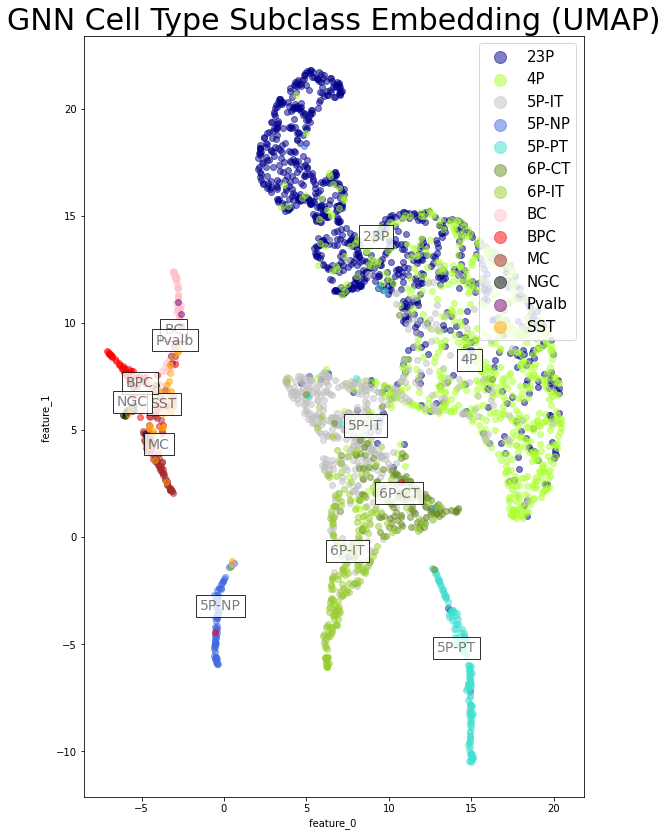

In [108]:
curr_ax = vml.plot_df_scatter_classification(
                X = df_plot[trans_cols].to_numpy().astype("float"),
                y = df_plot["cell_type"].to_numpy(),
                target_to_color = df_fine_color_map,
                ndim = len(trans_cols),
                title=method,
                use_labels_as_text_to_plot=True,
    fontsize = 14,
            )

mu.set_legend_outside_plot(curr_ax)
plt.legend(loc="upper right", markerscale=2., scatterpoints=1, fontsize=15)
plt.title("GNN Cell Type Subclass Embedding (UMAP)",fontsize = 30)

# Plotting the confusion matrix

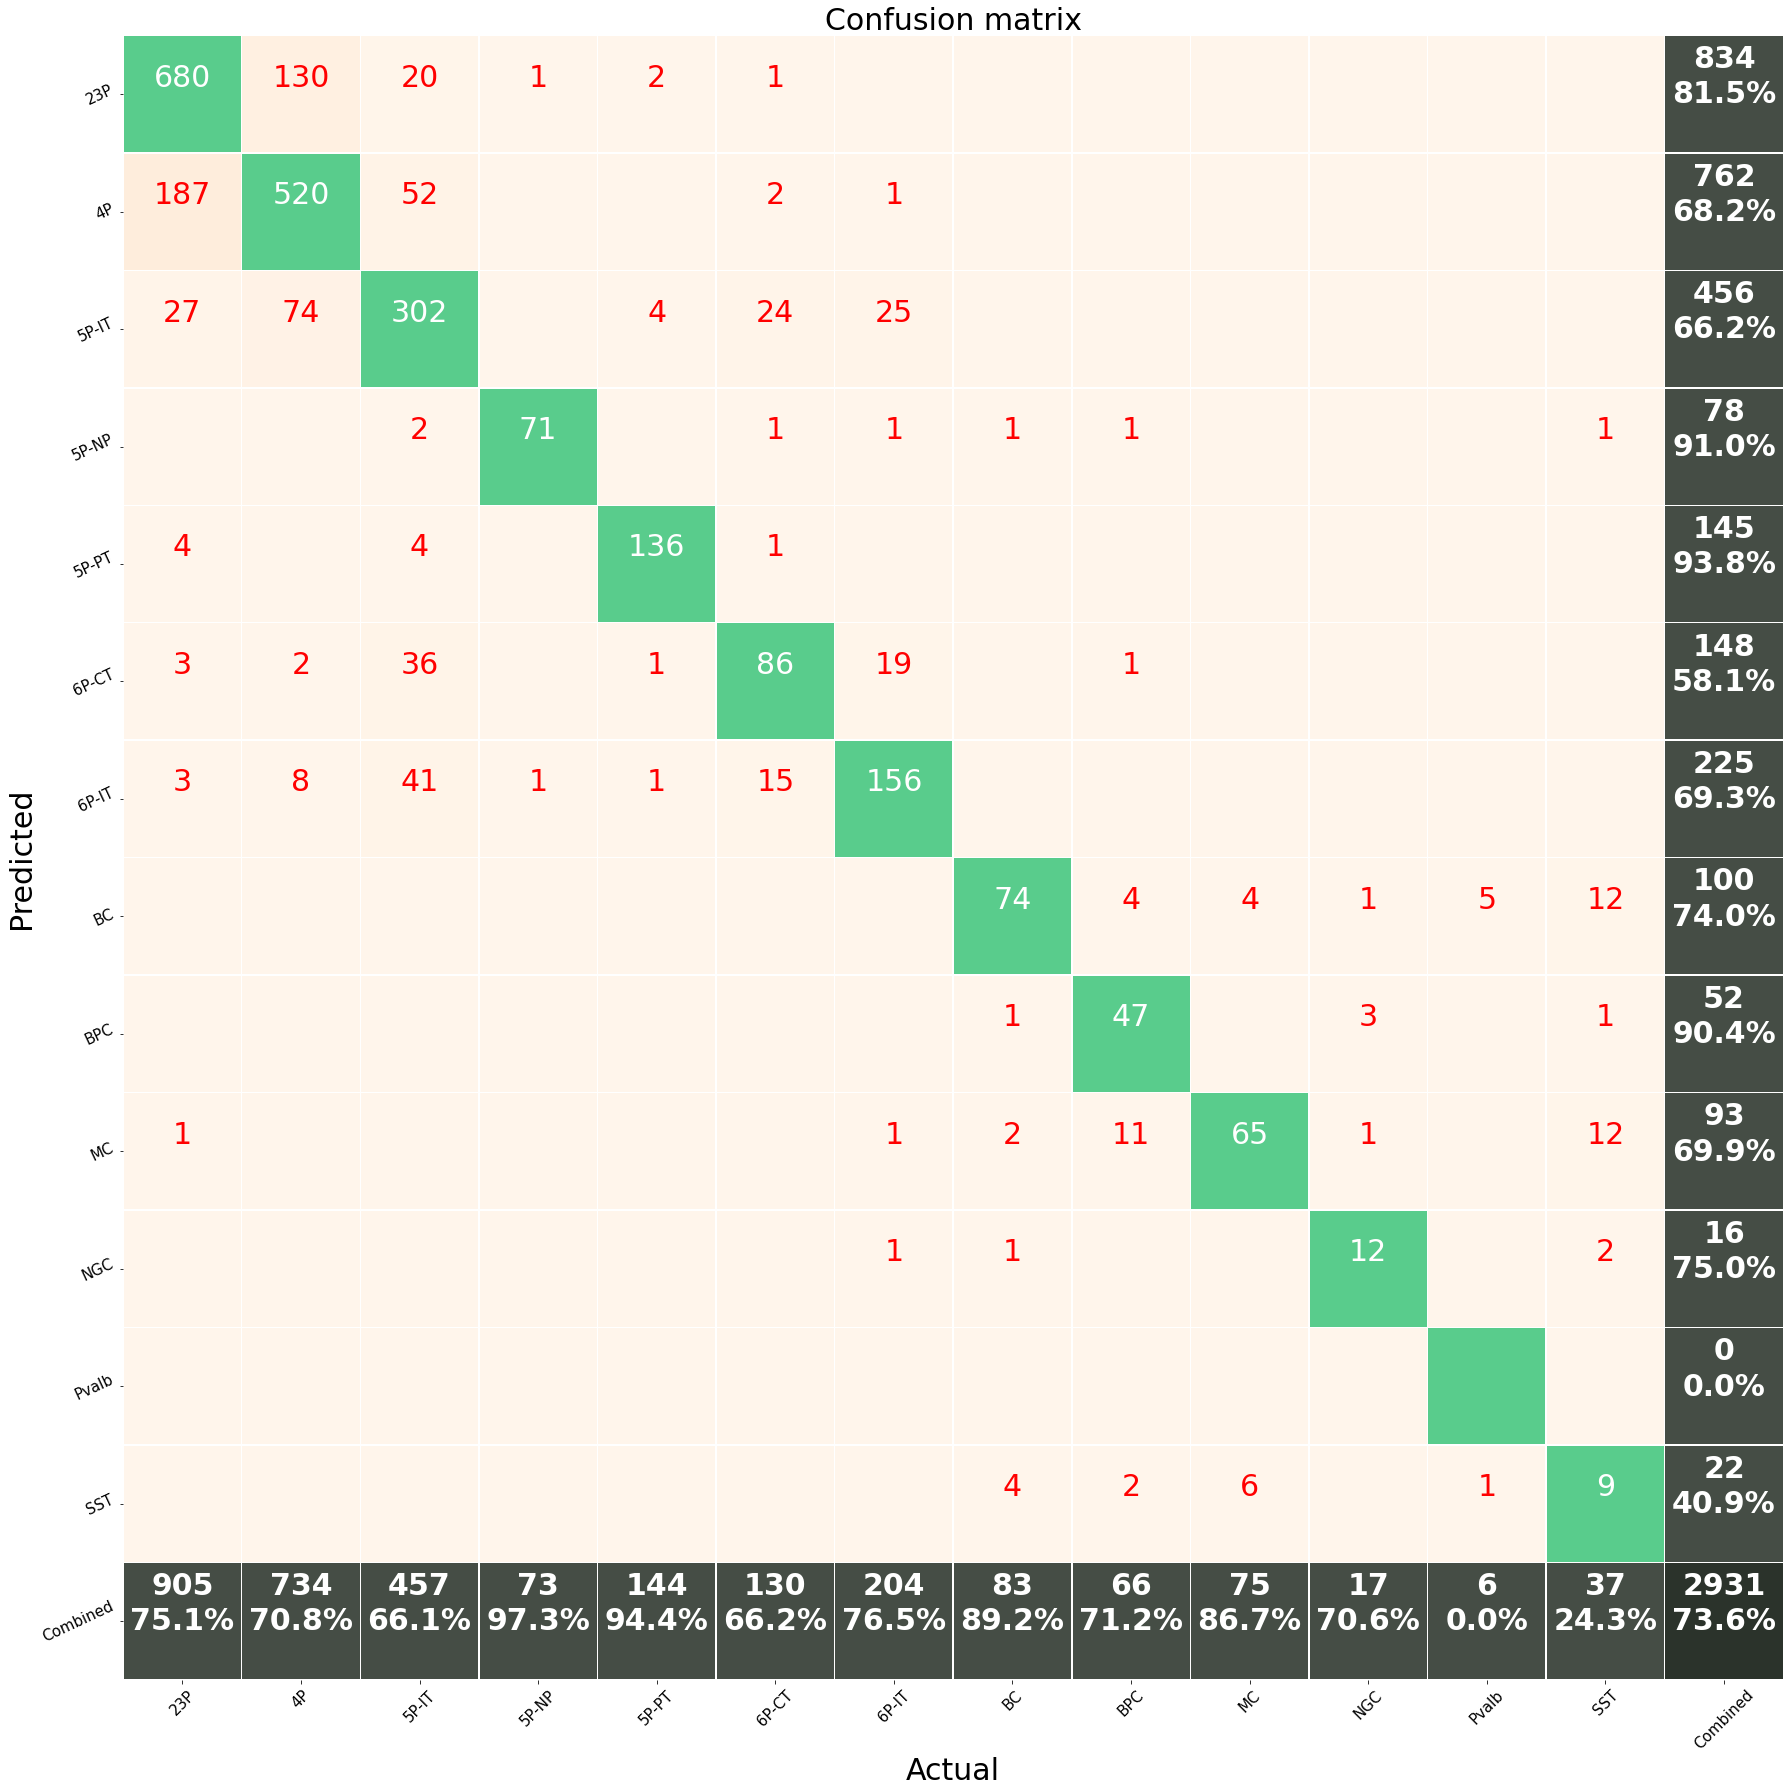

In [121]:
import statistics_visualizations as sviz

sviz.plot_pretty_confusion_matrix(
    y_true = df_input["cell_type"],
    y_pred = df_input["cell_type_predicted"],
    #labels = ctu.cell_type_fine_classifier_map_classes,
    labels = list(cell_type_map.keys()),
    figsize=(25,25),
    cell_fontsize = 30,
    ticklabel_fontsize=15)

# ---- E/I ANALYSIS ----

In [122]:
e_i_color_dict = {'excitatory': 'blue', 'inhibitory': 'red'}

Text(0.5, 1.0, 'GNN Cell Type Embedding (UMAP)')

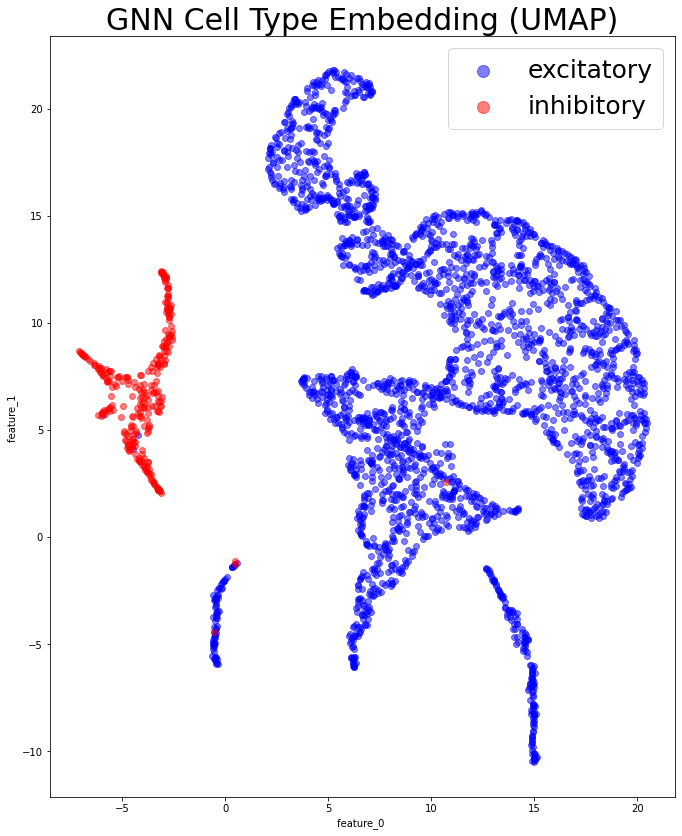

In [123]:
import matplotlib.pyplot as plt
vml.plot_df_scatter_classification(
                X = df_plot[trans_cols].to_numpy().astype("float"),
                y = df_plot["e_i"].to_numpy(),
                target_to_color = e_i_color_dict,
                ndim = len(trans_cols),
                title=method,
                use_labels_as_text_to_plot=False,
                set_legend_outside_plot = False,
                
            )
plt.legend(loc="upper right", markerscale=2., scatterpoints=1, fontsize=25)
plt.title("GNN Cell Type Embedding (UMAP)",fontsize = 30)

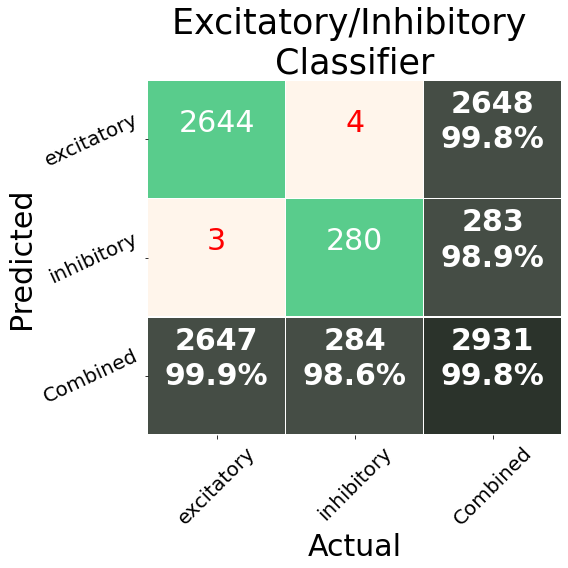

In [125]:
import statistics_visualizations as sviz

sviz.plot_pretty_confusion_matrix(
    y_true = df_plot["e_i"],
    y_pred = df_plot["e_i_predicted"],
    labels = list(e_i_color_dict.keys()),
    figsize=(8,8),
    cell_fontsize = 30,
    title = "Excitatory/Inhibitory \nClassifier",
    title_fontsize = 35,
    ticklabel_fontsize=20)

# Computing the Test Accuracy

In [126]:
data_loader_test = data_loader_mod(test_dataset + val_dataset, batch_size=batch_size,shuffle = False)
test_embed_df = ttu.forward_pass_embed_df(
    model,
    data_loader=data_loader_test,
    encoder_map = cell_type_map
)

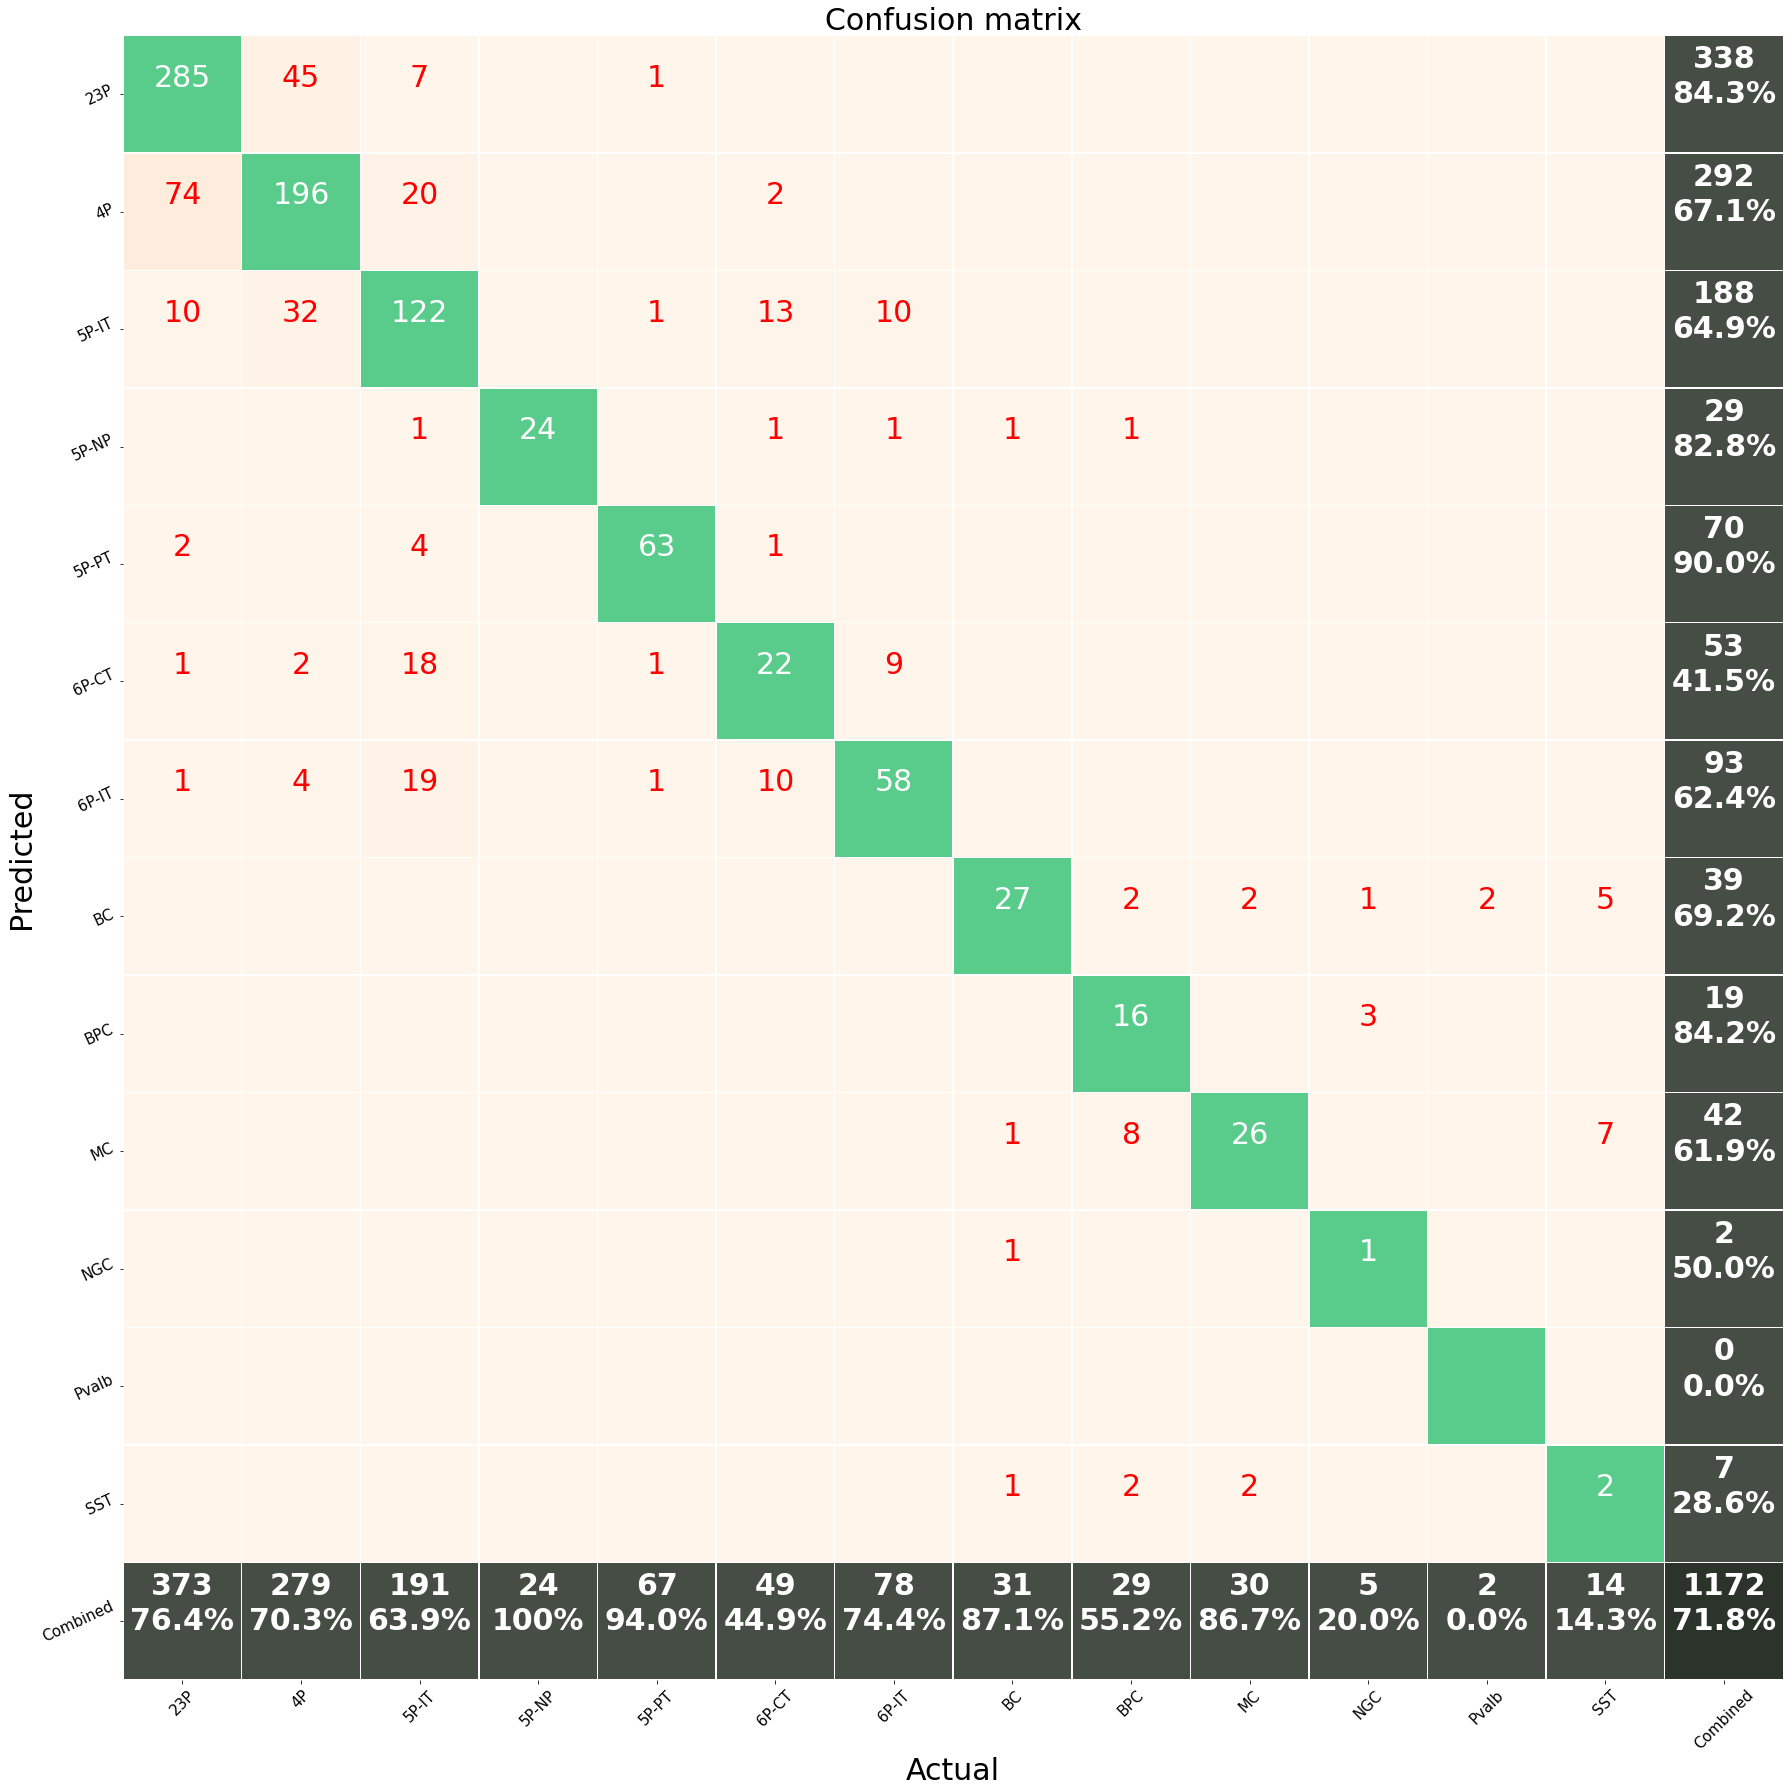

In [130]:
import statistics_visualizations as sviz

sviz.plot_pretty_confusion_matrix(
    y_true = test_embed_df["labels"],
    y_pred = test_embed_df["predicted_labels"],
    #labels = ctu.cell_type_fine_classifier_map_classes,
    labels = list(cell_type_map.keys()),
    figsize=(25,25),
    cell_fontsize = 30,
    ticklabel_fontsize=15)